Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Calculating Quantiles over user defined time-windows


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_kll_sketches_demo.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fbigquery-utils%2Fmaster%2Fnotebooks%2bigquery_kll_sketches_demo.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_kll_sketches_demo.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/bigquery/v1/32px.svg" alt="BigQuery Studio logo"><br> Open in BigQuery Studio
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_kll_sketches_demo.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>    

<div style="clear: both;"></div>

| | |
|-|-|
| Author |  [Nikunj Bhartia](https://github.com/nikunjbhartia)

# Demo Overview
- Data prep
- Quantile Sketch Creation
  1. Using Native KLL function: `KLL_QUANTILES.INIT_INT64()`
  2. Using BQ JS UDAF
    - The JS UD(A)Fs are loaded with OSS Datasketch KLL cpp library compiled to webassembly and published in all regional BQ public datasets
- Extracting quantiles using 7 different methods:
  1. Exact using `PERCENTILE_DISC()`
  2. Approx, without sketch support, using `APPROX_QUANTILES()`
  3. Approx, with sketch support, using BQ KLL JS UD(A)F
  4. Approx, with sketch support, using `KLL_QUANTILES.MERGE_POINT_INT64()`
  5. Approx, with sketch support, using `KLL_QUANTILES.MERGE_INT64()`
  6. Approx, with sketch support, using `KLL_QUANTILES.MERGE_PARTIAL()` -> `KLL_QUANTILES.EXTRACT_POINT_INT64()`
  7. Approx, with sketch support, using `KLL_QUANTILES.MERGE_PARTIAL()` -> `KLL_QUANTILES.EXTRACT_INT64()`

- Compare Results
- Compare query stats


# Setup

In [ ]:
#@title Provide Google Credentials to Colab Runtime (May Require Manually Copy/Pasting Authentication Code)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
#@title Enter Google Cloud/BigQuery Project ID for demo
project_id = '' #@param{type:"string"}

# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [ ]:
#@title Function to plot query stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_query_metrics_log_scale(df, prefix_list):
    # Filter dataframe based on query_tag prefixes
    filtered_df = df[df['query_tag'].str.startswith(tuple(prefix_list))]

    # Create figure with 3 subplots vertically stacked
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    bar_positions = np.arange(len(filtered_df['query_tag']))  # Positions for bars (e.g., [0, 1])

    # Plot 1: Total Slot Seconds (log scale)
    bars1 = ax1.bar(bar_positions, filtered_df['total_slot_sec'])
    ax1.bar(filtered_df['query_tag'], filtered_df['total_slot_sec'], color='lightgreen')
    ax1.set_yscale('log')  # Use logarithmic scale for y-axis
    ax1.set_title('Total Slot Seconds by Query Tag (Log Scale)')
    # ax1.set_xlabel('Query Tag')
    ax1.set_ylabel('Slot Seconds')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_slot_sec = max(filtered_df['total_slot_sec'])
    ax1.set_ylim(top=max_slot_sec * 5)  # increase the max value to create headroom


    # Plot 2: Total Time in Seconds (log scale)
    bars2 = ax2.bar(bar_positions, filtered_df['total_time_sec'])

    ax2.bar(filtered_df['query_tag'], filtered_df['total_time_sec'], color='skyblue')
    ax2.set_yscale('log')  # Use logarithmic scale for y-axis
    ax2.set_title('Total Execution Time by Query Tag (Log Scale)')
    # ax2.set_xlabel('Query Tag')
    ax2.set_ylabel('Time (seconds)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_time_sec = max(filtered_df['total_time_sec'])
    ax2.set_ylim(top=max_time_sec * 5)  # increase max value to create headroom

    # Plot 3: Total MB Processed (log scale)
    bars3 = ax3.bar(bar_positions, filtered_df['total_MB_processed'])
    ax3.bar(filtered_df['query_tag'], filtered_df['total_MB_processed'], color='salmon')
    ax3.set_yscale('log')  # Use logarithmic scale for y-axis
    ax3.set_title('Total MB Processed by Query Tag (Log Scale)')
    # ax3.set_xlabel('Query Tag')
    ax3.set_ylabel('MB Processed')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_mb_processed = max(filtered_df['total_MB_processed'])
    ax3.set_ylim(top=max_mb_processed * 5)  # increase max value to create headroom

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plots
    plt.show()

# Data Prep

In [ ]:
# Creating demo dataset in given project
output_dataset_id = 'kll_demo_us'
dataset_location = 'us'

# Combine project and dataset
dataset_id = f"{bq_client.project}.{output_dataset_id}"
dataset = bigquery.Dataset(dataset_id)
dataset.location = dataset_location

# Check to make sure output dataset exists, create it if not
try:
  bq_client.get_dataset(dataset_id)
  print(f"BigQuery dataset {dataset_id} exists\n")

except:
  print(f"BigQuery dataset {dataset_id} doesn't exist, so creating it\n")
  dataset = bq_client.create_dataset(dataset)
  print(f"BigQuery dataset {dataset_id} created in {dataset_location}")

In [ ]:
# Creating demo table

%%bigquery --project {project_id}
DROP table kll_demo_us.quantile_demo_table;
CREATE OR REPLACE TABLE kll_demo_us.quantile_demo_table (
  event_time TIMESTAMP,
  geography STRING,
  api STRING,
  api_response_time_ms INT64
)
PARTITION BY DATE(event_time)
CLUSTER BY geography, api;


In [ ]:
# Creating sample data : ~ 2.3 B Records
%%bigquery --project {project_id}
INSERT INTO kll_demo_us.quantile_demo_table (event_time, geography, api, api_response_time_ms)
WITH
  Parameters AS (
    SELECT
      30 AS num_days,
      3 AS num_apis,
      3 AS num_geos,
      100 AS max_concurrent_users  -- Maximum concurrent users per API/geo/second ( per user creates ~20 million entries keeping above same)
  ),
  BaseData AS (
    SELECT
      TIMESTAMP_SUB(
        CURRENT_TIMESTAMP(),
        INTERVAL (day_seq * 24 * 60 * 60) + (second_seq) SECOND  -- Calculate event_time
      ) AS event_time,
      geos.geo AS geography,
      apis.api AS api,
      CAST(
        CASE
          WHEN geos.geo = 'JAPAC' THEN
            CASE
              WHEN apis.api = '/users' THEN 10 + CAST(RAND() * 200 AS INT64)
              WHEN apis.api = '/products' THEN 50 + CAST(RAND() * 450 AS INT64)
              WHEN apis.api = '/orders' THEN 100 + CAST(RAND() * 900 AS INT64)
            END
          WHEN geos.geo = 'EMEA' THEN
            CASE
              WHEN apis.api = '/users' THEN 20 + CAST(RAND() * 300 AS INT64)
              WHEN apis.api = '/products' THEN 70 + CAST(RAND() * 530 AS INT64)
              WHEN apis.api = '/orders' THEN 120 + CAST(RAND() * 1080 AS INT64)
            END
          WHEN geos.geo = 'AMERICAS' THEN
            CASE
              WHEN apis.api = '/users' THEN 5 + CAST(RAND() * 150 AS INT64)
              WHEN apis.api = '/products' THEN 40 + CAST(RAND() * 400 AS INT64)
              WHEN apis.api = '/orders' THEN 90 + CAST(RAND() * 800 AS INT64)
            END
        END
        AS INT64
      ) AS api_response_time_ms,
    FROM
      (SELECT * FROM UNNEST(GENERATE_ARRAY(0, (SELECT num_days FROM Parameters) - 1)) AS day_seq)  -- Days
    CROSS JOIN
      (SELECT geo FROM UNNEST(['JAPAC', 'EMEA', 'AMERICAS']) AS geo) AS geos
    CROSS JOIN
      (SELECT api FROM UNNEST(['/users', '/products', '/orders']) AS api) AS apis
    CROSS JOIN
      (SELECT * FROM UNNEST(GENERATE_ARRAY(0, 86399)) as second_seq) -- Seconds in a day (0-86399)

  ),
  -- Simulate concurrent requests by spreading them across the same second
   SimulatedConcurrency AS (
        SELECT
            event_time,
            geography,
            api,
            (api_response_time_ms + MOD(CAST(RAND() * 200 AS INT64)*user_instance, 200)) as api_response_time_ms
        FROM BaseData
        CROSS JOIN (
          SELECT *
          FROM UNNEST(GENERATE_ARRAY(1, (SELECT max_concurrent_users FROM Parameters))) AS user_instance  --Simulate concurrent users.
        )
   )
SELECT
    TIMESTAMP_ADD(event_time, INTERVAL CAST(RAND() * 1000000 AS INT64) MICROSECOND) as event_time, --add microsecond randomness
    geography,
    api,
    (api_response_time_ms + CAST(RAND() * 200 AS INT64)) as api_response_time_ms
FROM SimulatedConcurrency;

In [ ]:
%%bigquery --project {project_id}
SELECT *
FROM kll_demo_us.quantile_demo_table
LIMIT 10

In [ ]:
%%bigquery --project {project_id}
-- Verify the row count.
SELECT COUNT(*) AS row_count FROM kll_demo_us.quantile_demo_table;

In [ ]:
%%bigquery --project {project_id}

-- Verify data distribution.
SELECT DATE(event_time) as event_date, geography, api, COUNT(*) AS cnt
FROM kll_demo_us.quantile_demo_table
GROUP BY 1, 2, 3
ORDER BY cnt DESC
LIMIT 10;

# Sketch Creation


## Native KLL Quantile Sketch Creation

[KLL16 Paper](https://arxiv.org/pdf/1603.05346v2)

In [ ]:
%%bigquery --project {project_id}
DROP TABLE `kll_demo_us.api_quantile_sketches_per_day_per_geo`;

In [ ]:
# Creating KLL Quantile sketches aggregating each day, geo, api
%%bigquery --project {project_id}
/* QUERY_TAG<(08) CREATE_NATIVE_SKETCHES_All> */
CREATE OR REPLACE TABLE `kll_demo_us.api_quantile_sketches_per_day_per_geo`
PARTITION BY event_date
CLUSTER BY geography, api AS
SELECT
  DATE(event_time) as event_date,
  geography,
  api,
  KLL_QUANTILES.INIT_INT64(api_response_time_ms, 1000) as response_time_ms_kll_sketch
  -- Precision 1000 == +/- 0.1%-ile error bounds
FROM kll_demo_us.quantile_demo_table
GROUP BY event_date, geography, api;

In [ ]:
# Sample Query to capture stats for creating sketches for 1 day
%%bigquery --project {project_id}
SELECT
/* QUERY_TAG<(09) CREATE_NATIVE_SKETCHES_1day> */
  DATE(event_time) as event_date,
  geography,
  api,
  KLL_QUANTILES.INIT_INT64(api_response_time_ms, 1000) as response_time_ms_kll_sketch -- Precision 1000 == +/- 0.1%-ile
FROM kll_demo_us.quantile_demo_table
WHERE DATE(event_time) = CURRENT_DATE() - 1
GROUP BY event_date, geography, api;

## OSS Datasketches KLL Quantile Sketch Creation using BQ UDAF

[datasketches-bigquery github](https://github.com/apache/datasketches-bigquery/tree/main/kll)

[datasketch kll precision](https://datasketches.apache.org/docs/KLL/KLLAccuracyAndSize.html)

Note: OSS KLL sketches are not compatible with Native KLL sketches ( same algorithm, different implementation )


In [ ]:
%%bigquery --project {project_id}
DROP TABLE `kll_demo_us.api_oss_quantile_sketches_per_day_per_geo`;

In [ ]:
# Creating KLL Quantile sketches aggregating each day, geo, api
%%bigquery --project {project_id}
/* QUERY_TAG<(10) CREATE_OSS_SKETCHES_All> */
CREATE OR REPLACE TABLE `kll_demo_us.api_oss_quantile_sketches_per_day_per_geo`
PARTITION BY event_date
CLUSTER BY geography, api AS
SELECT
  DATE(event_time) as event_date,
  geography,
  api,
  bqutil.datasketches.kll_sketch_float_build_k(api_response_time_ms, 2954) AS response_time_ms_kll_sketch
FROM kll_demo_us.quantile_demo_table
GROUP BY event_date, geography, api;

In [ ]:
# Sample Query to capture stats for creating sketches for 1 day
%%bigquery --project {project_id}
SELECT
/* QUERY_TAG<(11) CREATE_OSS_SKETCHES_1day> */
  DATE(event_time) as event_date,
  geography,
  api,
  bqutil.datasketches.kll_sketch_float_build_k(api_response_time_ms, 2954) AS kll_sketch
FROM kll_demo_us.quantile_demo_table
WHERE DATE(event_time) = CURRENT_DATE() - 1
GROUP BY event_date, geography, api;

# Quantile Extraction


## PERCENTILE_DISC()

In [ ]:
# Exracting quantiles using exact PERCENTILE_DISC function

%%bigquery precentile_disc_df --project {project_id}
/* QUERY_TAG<(01) PERCENTILE_DISC> */
SELECT
  geography,
  api,
  PERCENTILE_DISC(api_response_time_ms, 0.5) OVER (PARTITION BY geography, api) AS median_response_time,
  PERCENTILE_DISC(api_response_time_ms, 0.9) OVER (PARTITION BY geography, api) AS p90_response_time,
  PERCENTILE_DISC(api_response_time_ms, 0.99) OVER (PARTITION BY geography, api) AS p99_response_time
FROM kll_demo_us.quantile_demo_table
WHERE event_time >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)
QUALIFY ROW_NUMBER() OVER (PARTITION BY geography, api ORDER BY event_time DESC) = 1
ORDER BY geography, api;

In [ ]:
precentile_disc_df

## APPROX_QUANTILES()


In [ ]:
# Exracting quantiles using APPROX_QUANTILES function
%%bigquery approx_quantiles_df --project {project_id}
/* QUERY_TAG<(02) APPROX_QUANTILES> */
SELECT
  geography,
  api,
  approx_quantiles_array[OFFSET(50)] AS median_response_time,
  approx_quantiles_array[OFFSET(90)] AS p90_response_time,
  approx_quantiles_array[OFFSET(99)] AS p99_response_time
FROM (
  SELECT
    geography,
    api,
    APPROX_QUANTILES(api_response_time_ms, 100) as approx_quantiles_array
  FROM kll_demo_us.quantile_demo_table
  WHERE event_time >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)
  GROUP BY geography, api)
ORDER BY geography, api;

In [ ]:
approx_quantiles_df

## BQ UDAF Datasketch KLL

In [ ]:
# Exracting quantiles using OSS Datasketch KLL library loaded to BQ UDAF
%%bigquery oss_kll_merge_df --project {project_id}
/* QUERY_TAG<(03) BQUDAF.OSS_KLL_MERGE_EXTRACT> */
SELECT
  geography,
  api,
  bqutil.datasketches.kll_sketch_float_get_quantile(merged_kll_sketch, 0.5, true) AS median_response_time,
  bqutil.datasketches.kll_sketch_float_get_quantile(merged_kll_sketch, 0.9, true) AS p90_response_time,
  bqutil.datasketches.kll_sketch_float_get_quantile(merged_kll_sketch, 0.99, true) AS p99_response_time
FROM (
  SELECT
    geography,
    api,
    bqutil.datasketches.kll_sketch_float_merge_k(response_time_ms_kll_sketch, 2954) as merged_kll_sketch
  FROM `kll_demo_us.api_oss_quantile_sketches_per_day_per_geo`
  WHERE event_date >= DATETIME_SUB(CURRENT_DATETIME(), INTERVAL 7 DAY)
  GROUP BY geography, api
  ORDER BY geography, api)

In [ ]:
oss_kll_merge_df

## KLL_QUANTILES.MERGE_POINT_INT64

In [ ]:
# Exracting quantiles using KLL_QUANTILES sketch function - MERGE_POINT_*
%%bigquery kll_merge_point_df --project {project_id}
/* QUERY_TAG<(04) KLL.MERGE_POINT> */
SELECT
  geography,
  api,
  KLL_QUANTILES.MERGE_POINT_INT64(response_time_ms_kll_sketch, 0.5) AS median_response_time,
  KLL_QUANTILES.MERGE_POINT_INT64(response_time_ms_kll_sketch, 0.9) AS p90_response_time,
  KLL_QUANTILES.MERGE_POINT_INT64(response_time_ms_kll_sketch, 0.99) AS p99_response_time
FROM `kll_demo_us.api_quantile_sketches_per_day_per_geo`
WHERE event_date >= DATETIME_SUB(CURRENT_DATETIME(), INTERVAL 7 DAY)
GROUP BY geography, api
ORDER BY geography, api;

In [ ]:
kll_merge_point_df

## KLL_QUANTILES.MERGE_INT64

In [ ]:
# Exracting quantiles using KLL_QUANTILES sketch function - MERGE_POINT_*
%%bigquery kll_merge_df --project {project_id}
/* QUERY_TAG<(05) KLL.MERGE> */
SELECT
  geography,
  api,
  approx_quantiles_array[OFFSET(50)] AS median_response_time,
  approx_quantiles_array[OFFSET(90)] AS p90_response_time,
  approx_quantiles_array[OFFSET(99)] AS p99_response_time
FROM (
  SELECT
    geography,
    api,
    KLL_QUANTILES.MERGE_INT64(response_time_ms_kll_sketch, 100) AS approx_quantiles_array
  FROM `kll_demo_us.api_quantile_sketches_per_day_per_geo`
  WHERE event_date >= DATETIME_SUB(CURRENT_DATETIME(), INTERVAL 7 DAY)
  GROUP BY geography, api)
ORDER BY geography, api;

In [ ]:
kll_merge_df

## KLL_QUANTILES.MERGE_PARTIAL -> EXTRACT_POINT_INT64

In [ ]:
# Exracting quantiles using KLL_QUANTILES sketch function - Using MERGE_PARTIAL, EXTRACT_POINT_INT64
%%bigquery kll_merge_partial_extract_point_df --project {project_id}
/* QUERY_TAG<(06) KLL.MERGE_PARTIAL_EXTRACT_POINT> */
SELECT
  geography,
  api,
  KLL_QUANTILES.EXTRACT_POINT_INT64(merged_sketch, 0.5) AS median_response_time,
  KLL_QUANTILES.EXTRACT_POINT_INT64(merged_sketch, 0.9) AS p90_response_time,
  KLL_QUANTILES.EXTRACT_POINT_INT64(merged_sketch, 0.99) AS p99_response_time
FROM (
  SELECT
    geography,
    api,
    KLL_QUANTILES.MERGE_PARTIAL(response_time_ms_kll_sketch) as merged_sketch
  FROM `kll_demo_us.api_quantile_sketches_per_day_per_geo`
  WHERE event_date >= DATETIME_SUB(CURRENT_DATETIME(), INTERVAL 7 DAY)
  GROUP BY geography, api
  ORDER BY geography, api)

In [ ]:
kll_merge_partial_extract_point_df

## KLL_QUANTILES.MERGE_PARTIAL -> EXTRACT_INT64

In [ ]:
# Exracting quantiles using KLL_QUANTILES sketch function - Using MERGE_PARTIAL, EXTRACT_INT64
%%bigquery kll_merge_partial_extract_df --project {project_id}
/* QUERY_TAG<(07) KLL.MERGE_PARTIAL_EXTRACT> */
SELECT
  geography,
  api,
  approx_quantiles_array[OFFSET(50)] AS median_response_time,
  approx_quantiles_array[OFFSET(90)] AS p90_response_time,
  approx_quantiles_array[OFFSET(99)] AS p99_response_time
FROM (
  SELECT
    geography,
    api,
    KLL_QUANTILES.EXTRACT_INT64(merged_sketch, 100) AS approx_quantiles_array
  FROM (
    SELECT
      geography,
      api,
      KLL_QUANTILES.MERGE_PARTIAL(response_time_ms_kll_sketch) as merged_sketch
    FROM `kll_demo_us.api_quantile_sketches_per_day_per_geo`
    WHERE event_date >= DATETIME_SUB(CURRENT_DATETIME(), INTERVAL 7 DAY)
    GROUP BY geography, api
  )
)
ORDER BY geography, api

In [ ]:
kll_merge_partial_extract_df

# Comparing Results

In [ ]:
# Comparing P99 values from each of the 4 methods
# https://screenshot.googleplex.com/6iuQEYdKupF6UyC : Exact results for P98.9 and P99.1

# Select desired columns from each DataFrame *before* merging.
kll_merge_partial_extract_point_df_2 = kll_merge_partial_extract_point_df[['geography', 'api', 'p99_response_time']]
kll_merge_partial_extract_df_2 = kll_merge_partial_extract_df[['geography', 'api', 'p99_response_time']]
precentile_disc_df_2 = precentile_disc_df[['geography', 'api', 'p99_response_time']]
approx_quantiles_df_2 = approx_quantiles_df[['geography', 'api', 'p99_response_time']]
kll_merge_point_df_2 = kll_merge_point_df[['geography', 'api', 'p99_response_time']]
kll_merge_df_2 = kll_merge_df[['geography', 'api', 'p99_response_time']]
oss_kll_merge_df_2 = oss_kll_merge_df[['geography', 'api', 'p99_response_time']]

# Rename the 'p99_response_time' column *before* merging.
kll_merge_partial_extract_point_df_2 = kll_merge_partial_extract_point_df_2.rename(columns={'p99_response_time': 'P99_kll_merge_partial_extract_point'})
kll_merge_partial_extract_df_2 = kll_merge_partial_extract_df_2.rename(columns={'p99_response_time': 'P99_kll_merge_partial_extract'})
precentile_disc_df_2 = precentile_disc_df_2.rename(columns={'p99_response_time': 'P99_exact'})
approx_quantiles_df_2 = approx_quantiles_df_2.rename(columns={'p99_response_time': 'P99_approx_quantile'})
kll_merge_point_df_2 = kll_merge_point_df_2.rename(columns={'p99_response_time': 'P99_kll_merge_point'})
kll_merge_df_2 = kll_merge_df_2.rename(columns={'p99_response_time': 'P99_kll_merge'})
oss_kll_merge_df_2 = oss_kll_merge_df_2.rename(columns={'p99_response_time': 'P99_oss_kll_merge_extract'})

# Merge the DataFrames.
merged_df = precentile_disc_df_2.merge(approx_quantiles_df_2, on=['geography', 'api'], how='outer') \
    .merge(kll_merge_point_df_2, on=['geography', 'api'], how='outer') \
    .merge(kll_merge_df_2, on=['geography', 'api'], how='outer') \
    .merge(kll_merge_partial_extract_point_df_2, on=['geography', 'api'], how='outer') \
    .merge(kll_merge_partial_extract_df_2, on=['geography', 'api'], how='outer') \
    .merge(oss_kll_merge_df_2, on=['geography', 'api'], how='outer')


P99_compare_all_df = merged_df

p99_columns = ['P99_kll_merge_partial_extract_point', 'P99_kll_merge_partial_extract', 'P99_exact', 'P99_approx_quantile', 'P99_kll_merge_point', 'P99_kll_merge', 'P99_oss_kll_merge_extract']
# Filter rows where the number of unique values > 1
P99_with_different_values_df = merged_df[merged_df[p99_columns].nunique(axis=1) > 1]

# Comparing results of P99 for all 4 methods
P99_compare_all_df

# Comparing Query Stats

In [ ]:
%%bigquery stats_df --project {project_id}
DECLARE CURRENT_DT DATE DEFAULT CURRENT_DATE();

SELECT
  query_tag,
  total_time_sec,
  total_slot_sec,
  ROUND(LAG(total_slot_sec, 1, 1) OVER( ORDER BY query_tag ASC ) / total_slot_sec, 1) as slot_sec_prev_vs_curr,
  total_MB_processed,
  ROUND(LAG(total_MB_processed, 1, 1) OVER( ORDER BY query_tag ASC ) / total_MB_processed, 1) as total_MB_prev_vs_curr,
  shuffle_output_MB,
  cache_hit,
  creation_time
FROM (
  SELECT *
  FROM (
    SELECT
      REGEXP_EXTRACT(query, r'/\* QUERY_TAG<(.*?)> \*/') AS query_tag,
      (TIMESTAMP_DIFF(end_time, start_time, MILLISECOND)/1000) as total_time_sec,
      (total_slot_ms/1000) as total_slot_sec,
      (total_bytes_processed/pow(1024,2)) AS total_MB_processed,
      -- (total_bytes_billed/pow(1024,2)) AS total_Mbytes_billed,
      (SELECT SUM(stage.shuffle_output_bytes) FROM UNNEST(job_stages) stage)/pow(1024,2) AS shuffle_output_MB,
      -- (SELECT SUM(stage.shuffle_output_bytes_spilled) FROM UNNEST(job_stages) stage)/pow(1024,2) AS shuffle_output_spilled_MB,
      cache_hit,
      creation_time
    FROM `region-us`.INFORMATION_SCHEMA.JOBS_BY_PROJECT
    WHERE state='DONE'
    AND DATE(creation_time) = CURRENT_DT
    AND creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 10 MINUTE) AND CURRENT_TIMESTAMP()
    AND query LIKE "%QUERY_TAG%")
  WHERE query_tag IS NOT NULL
  QUALIFY ROW_NUMBER() OVER (PARTITION BY query_tag ORDER BY creation_time DESC) = 1)
ORDER BY query_tag ASC;


In [ ]:
prefix_list = [ '(01)', '(02)', '(03)', '(04)', '(05)', '(06)', '(07)']
plot_query_metrics_log_scale(stats_df, prefix_list)

In [ ]:
stats_df

# Appendix

## Native KLL Sketch Sizes


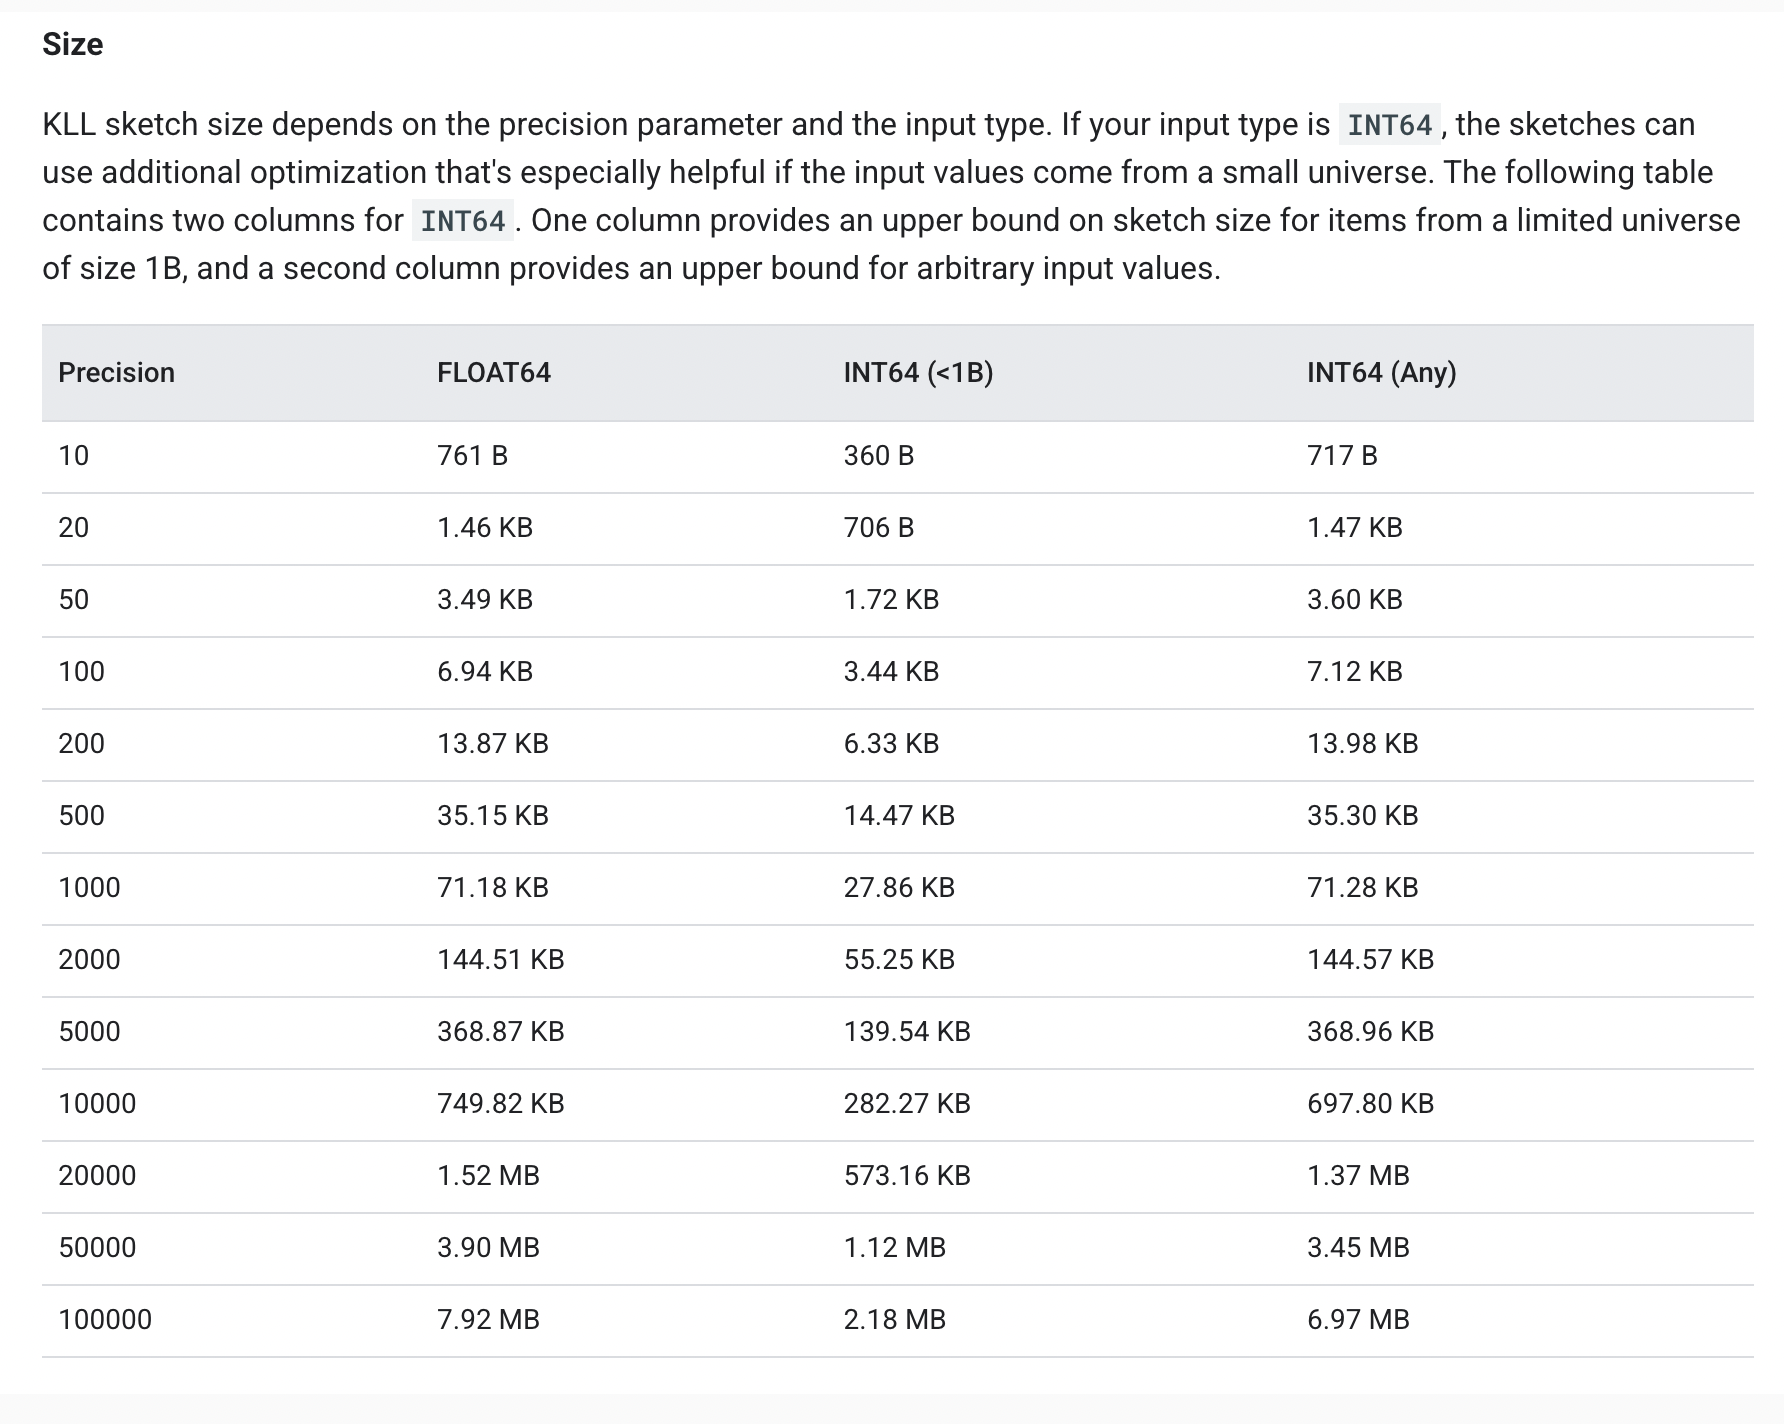

## Native KLL Precision

suppose you want to find the median value, Φ = 0.5, and you use the default precision of 1000.

Then the rank of the value returned by the KLL_QUANTILES.EXTRACT_POINT function differs from the true rank by at most n/1000 in 99.999% of cases.

In other words, the returned value is almost always between the 49.9th and 50.1st percentiles.

If you have 1,000,000 items in your sketch, then the rank of the returned median is almost always between 499,000 and 501,000.


| Precision      | Error Bound        | Requested Quantile | Approx Result Range (with 99.999% CI)  |
|----------------|--------------------|--------------------|-----------------------|
| 100            | ± 1%-ile           | P50                | P49 - P51             |
| 1000 (default) | ± 0.1%-ile         | P80                | P79.9 - P80.1         |
| 5000           | ± 0.02%-ile        | P75                | P74.98 - P75.02       |
| 10000          | ± 0.01%-ile        | P99.9                | P99.89 - P99.91       |
| 100000         | ± 0.001%-ile       | P99.99                | P99.989 - P99.991     |



